# Критическая температура

## Описание исследования

Явление сверхпроводимость одно из самых удивительных по своей природе, но объяснить его с классической точки зрения невозможно.
Данное явление было открыто голландским физиком Хейке Камерлинг-Оннес в **1911 году**.

**Сверхпроводимость** — свойство некоторых веществ и материалов, электрическое сопротивление которых при понижении температуры до определенного уровня падает до нуля. Сверхпроводимость возникает скачком при понижении температуры. Температура при которой возникает скачок называется критической температурой.

Несмотря на то, что сверхпроводимость была открыта больше века назад, многие её свойства плохо изучены, например, связь между сверхпроводимостью и химическими/структурными свойствами материалов.

Вам предлагается разработать алгоритмы машинного обучения, которые позволяют установить связь между химическим составом, различными свойствами сверхпроводниками и их критической температурой.

*Примечание:*

*Задача предоставлена в рамках программы классического ML SkillFactory x НИЯУ МИФИ, программы "Машинное обучение с учителем" Яндекс х НИЯУ МИФИ, а также программы "Прикладного анализа данных" Цифровой кафедры НИЯУ МИФИ.*

*Данные были собраны как из открытых источников, так и сгенерированы самостоятельно.*

## Описание датасета

Данные о сверхпроводниках взяты из базы данных сверхпроводящих материалов, собранной Национальным институтом материаловедения Японии NIMS. Данные содержат сведения о 21 263 сверхпроводников.
- Тренировочный набор - 17 010 строк.
- Тестовый набор - 4 253 строк.

Для каждого сверхпроводника в данных приведены полная химическая формула сверхпроводника, а также 8 основных химических свойств (абсолютное значение, среднее, взвешенное среднее и так далее): атомная масса, энергия ионизации, радиус атома, плотность, удельная теплота плавления, энергия сродства к электрону, теплопроводность, валентность.

- train.csv - набор тренировочных данных, содержащих различные свойства суперпроводников
- formula_train.csv - набор тренировочных данных, содержащих химический состав суперпроводников
- test.csv - набор тестовых данных, содержащих различные свойства суперпроводников
- formula_test.csv - набор тестовых данных, содержащих химический состав суперпроводников

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBRegressor

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from IPython.display import Image

## Исследование и анализ датасета

Считываем тренировочные данные:

In [2]:
train = pd.read_csv('train.csv')
formula_train = pd.read_csv('formula_train.csv')

In [3]:
print(f"Train dataset shape: {train.shape}")
print(f"Train_formula dataset shape: {formula_train.shape}")

Train dataset shape: (17010, 82)
Train_formula dataset shape: (17010, 88)


In [4]:
train.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               17010 non-null  int64  
 1   mean_atomic_mass                 17010 non-null  float64
 2   wtd_mean_atomic_mass             17010 non-null  float64
 3   gmean_atomic_mass                17010 non-null  float64
 4   wtd_gmean_atomic_mass            17010 non-null  float64
 5   entropy_atomic_mass              17010 non-null  float64
 6   wtd_entropy_atomic_mass          17010 non-null  float64
 7   range_atomic_mass                17010 non-null  float64
 8   wtd_range_atomic_mass            17010 non-null  float64
 9   std_atomic_mass                  17010 non-null  float64
 10  wtd_std_atomic_mass              17010 non-null  float64
 11  mean_fie                         17010 non-null  float64
 12  wtd_mean_fie      

Считываем тестовые данные:

In [6]:
formula_train.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [7]:
formula_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   H              17010 non-null  float64
 1   He             17010 non-null  int64  
 2   Li             17010 non-null  float64
 3   Be             17010 non-null  float64
 4   B              17010 non-null  float64
 5   C              17010 non-null  float64
 6   N              17010 non-null  float64
 7   O              17010 non-null  float64
 8   F              17010 non-null  float64
 9   Ne             17010 non-null  int64  
 10  Na             17010 non-null  float64
 11  Mg             17010 non-null  float64
 12  Al             17010 non-null  float64
 13  Si             17010 non-null  float64
 14  P              17010 non-null  float64
 15  S              17010 non-null  float64
 16  Cl             17010 non-null  float64
 17  Ar             17010 non-null  int64  
 18  K     

In [8]:
test = pd.read_csv('test.csv')
formula_test = pd.read_csv('formula_test.csv')

In [9]:
print(f"Test dataset shape: {test.shape}")
print(f"Test_formula dataset shape: {formula_test.shape}")

Test dataset shape: (4253, 81)
Test_formula dataset shape: (4253, 87)


## Предобработка данных

### Объединение train и formula_train

Т.к. у нас два представления одного и того же объекта:
- train.csv — агрегированные физико-химические признаки (81 колонка + цель)
- formula_train.csv — элементный состав (86 элементов + цель + формула)

Это дополняющие друг друга источники информации. Чтобы модель использовала всю доступную информацию, нужно объединить их. Иначе мы либо игнорируем состав, либо игнорируем агрегатные свойства.

Удаляем `critical_temp` и `material` из формулы:
- Зачем удаляем `critical_temp` из `formula_train`?
Потому что он уже есть в train.csv. При объединении он продублируется, и если оставить — будет утечка данных (признак = целевая переменная). Это критическая ошибка.

- Зачем удаляем `material`?
Это строка с формулой (`"Ba0.2La1.8Cu1O4"`). Она нечисловая, не подходит для большинства моделей без сложной обработки (например, NLP или парсинга), а вся её числовая информация уже закодирована в one-hot-столбцах элементов. Поэтому удаляем как избыточную.

In [10]:
X_train = train.drop(columns=['critical_temp'])
y_train = train['critical_temp']

In [11]:
formula_train_clean = formula_train.drop(columns=['critical_temp', 'material'])
formula_test_clean = formula_test.drop(columns=['material'])

In [12]:
X_train_full = pd.concat([X_train, formula_train_clean], axis=1)
X_test_full = pd.concat([test, formula_test_clean], axis=1)

### Удаление константных/квазиконстантных признаков (VarianceThreshold)

Этот код удаляет бесполезные признаки, которые почти не меняются от образца к образцу — например, такие, в которых ненулевое значение встречается менее чем в 10 сверхпроводниках из 17 010. 

Такие признаки не помогают модели отличать материалы с разной критической температурой, а только усложняют обучение и могут вызывать ошибки (например, деление на ноль при расчёте корреляции). 

Используется стандартный инструмент `VarianceThreshold`, который оставляет только те столбцы, где значения достаточно разнообразны.

In [13]:
# Порог: признак меняется хотя бы в 10 объектах из 17010 → var > (10/17010)*(1 - 10/17010)
threshold = (10 / len(X_train_full)) * (1 - 10 / len(X_train_full))
sel = VarianceThreshold(threshold=threshold)
sel.fit(X_train_full)

# Список оставшихся колонок
cols_to_keep = X_train_full.columns[sel.get_support()]
print(f"Удалено {X_train_full.shape[1] - len(cols_to_keep)} признаков")

# Применим фильтр
X_train_full = X_train_full[cols_to_keep].copy()
X_test_full = X_test_full[cols_to_keep].copy()

Удалено 9 признаков


### Анализ распределения целевой переменной и корреляций

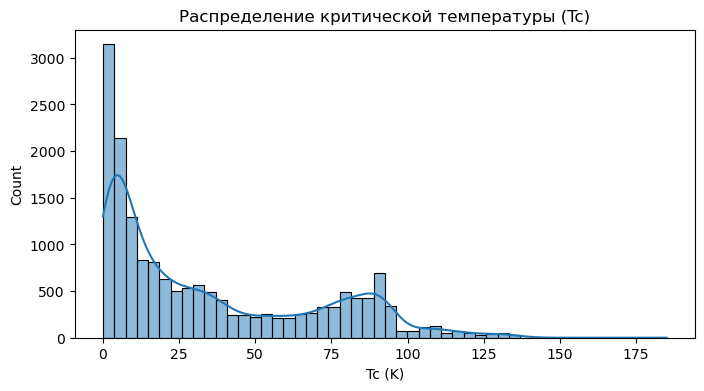

wtd_std_ThermalConductivity    0.720447
range_ThermalConductivity      0.686461
range_atomic_radius            0.655900
std_ThermalConductivity        0.652652
wtd_mean_Valence               0.632833
wtd_entropy_atomic_mass        0.626545
wtd_gmean_Valence              0.616134
range_fie                      0.604288
wtd_entropy_atomic_radius      0.603332
number_of_elements             0.601792
mean_Valence                   0.601103
wtd_std_atomic_radius          0.600576
entropy_Valence                0.599583
wtd_entropy_Valence            0.589791
wtd_std_fie                    0.584195
gmean_Valence                  0.574112
entropy_fie                    0.568254
O                              0.565883
Ba                             0.564602
wtd_entropy_FusionHeat         0.562708
dtype: float64


In [14]:
# Распределение Tc
plt.figure(figsize=(8, 4))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Распределение критической температуры (Tc)')
plt.xlabel('Tc (K)')
plt.show()

# Топ-20 признаков по корреляции с Tc
corr = X_train_full.corrwith(y_train).abs().sort_values(ascending=False)
top20 = corr.head(20)
print(top20)

**Главные параметры** — это данные по **теплопроводности, размеру атомов, энергии и валентности**, а также **наличие кислорода и бария**. Это логично, ведь речь идёт о высокотемпературных сверхпроводниках.

## Подбор признаков, их анализ и оценка важности

Используем **XGBoost** для оценки важности признаков.

Обоснование:
- **устойчив к шуму** и не требует масштабирования,
- **обрабатывает нелинейности** и взаимодействия признаков (важно для материаловедения),
- встроенная оценка важности (`gain`) — **надёжнее корреляции**, так как учитывает вклад в деревьях,
- **часто достигает наилучших результатов на табличных данных**, не требуя сложной настройки.

In [15]:
xgb = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
xgb.fit(X_train_full, y_train)

importance = pd.Series(xgb.feature_importances_, index=X_train_full.columns).sort_values(ascending=False)

print(importance.head(30))

Cu                              0.520611
range_ThermalConductivity       0.075342
gmean_Valence                   0.074022
Ba                              0.040330
Ca                              0.036273
range_atomic_radius             0.016451
entropy_Density                 0.012964
Zn                              0.010556
Fe                              0.009753
range_ElectronAffinity          0.008115
Pr                              0.007947
Mg                              0.007663
wtd_gmean_Valence               0.007302
range_fie                       0.007297
wtd_std_Valence                 0.007097
std_atomic_mass                 0.006542
wtd_mean_Valence                0.005859
wtd_gmean_Density               0.005477
entropy_ThermalConductivity     0.004772
std_Density                     0.004564
wtd_entropy_Valence             0.003740
std_ElectronAffinity            0.003616
wtd_std_ElectronAffinity        0.003297
Sr                              0.003252
gmean_Density   

**Анализ важности:**

- Cu (0.52) — доминирует. Это ожидаемо: большинство высокотемпературных сверхпроводников — купраты.
- Ba, Ca, Fe, Zn, Pr, Sr, Hg — тоже известные компоненты (YBCO, железные пниктиды и др.).

**Среди агрегатных признаков важны:**
- `range_ThermalConductivity`,
- `gmean_Valence`,
- `range_atomic_radius`.

Они отражают разнородность состава, что критично для критической температуры.

**Вывод:**

Модель правильно выделяет физически значимые факторы.

Удалять признаки дальше не нужно — даже слабые элементы могут быть важны в комбинациях.

## Обучение нескольких моделей, их сравнение

Сравним четыре модели с кросс-валидацией по MSE:
- LinearRegression (**по условию проекта**),
- Ridge (линейная, с регуляризацией),
- Random Forest,
- XGBoost (с разумными дефолтами, без долгой оптимизации).

**Цель** — выбрать модель для финальной настройки.

In [16]:
models = {
    "Linear": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-2, 3, 50), cv=5),
    "RF": RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1),
    "XGB": XGBRegressor(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    # В scikit-learn функция cross_val_score с scoring='neg_mean_squared_error' возвращает отрицательные значения MSE (по соглашению: все скоры максимизируются, а MSE нужно минимизировать).
    scores = -cross_val_score(model, X_train_full, y_train, cv=kf, scoring='neg_mean_squared_error')
    results[name] = scores.mean()
    print(f"{name} CV MSE: {scores.mean():.2f} ± {scores.std():.2f}")

Linear CV MSE: 771.32 ± 688.71
Ridge CV MSE: 336.45 ± 75.19
RF CV MSE: 103.10 ± 5.66
XGB CV MSE: 87.02 ± 4.13


## Выбор лучшей модели и объяснение выбора

**Результаты однозначны:**
- **XGBoost** значительно лучше: MSE ≈ 87,
- **Random Forest** — на втором месте (103),
- **Ridge** — слаб для этой задачи (336), что логично: зависимость нелинейная,
- **Linear** - худший результат (771).

**Решение:** будем использовать XGBoost.

## Предсказание на тестовых данных

In [20]:
best_params = {
    'n_estimators': 800,
    'max_depth': 10,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 2.0,
    'min_child_weight': 5,
    'reg_alpha': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

model = XGBRegressor(**best_params)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = -cross_val_score(model, X_train_full, y_train, cv=kf, scoring='neg_mean_squared_error')

print(f"CV MSE: {mse_scores.mean():.2f} ± {mse_scores.std():.2f}")

model.fit(X_train_full, y_train)

y_pred = model.predict(X_test_full)

submission = pd.DataFrame({
    'index': range(len(y_pred)),
    'critical_temp': y_pred
})

submission.to_csv('submission.csv', index=False)

CV MSE: 83.92 ± 5.89


CV MSE: 83.92 ± 5.89

## Скриншот с лидерборда Kaggle

In [ ]:
Image(filename='kaggle_leaderboard.png')